## Looking at the data first

Since the vast majority of the HAM10000 dataset consists of images, there is relatively little tabular data to clean and wrangle. However, there is a .csv file containing the ID code for the condition, the ID code of the image, the diagnoses, the age of the patient, the sex of the patient, and the location of the condition, the first ten rows of which are shown below.

In [1]:
#Importing necessary modules.
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_absolute_error, accuracy_score, f1_score
from sklearn.model_selection import GridSearchCV
import numpy as np

In [2]:
#Loading the dataset
data = pd.read_csv(r'C:\Users\songs\Desktop\CSV files\dataverse_files\HAM10000_metadata.csv')
data.head(10)

,Unnamed: 0,lesion_id,image_id,dx,dx_type,age,sex,localization
0,0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


According to the website where the data was found, the columns are as follows:
* **lesion_id** - Lesion ID (identification code for the skin condition, may or may not be unique for every picture as multiple pictures may be taken for the same condition
* **image_id** - Image ID (identification code for the image itself, is unique for every picture
* **dx** - Diagnosis
* **dx_type** - How the Diagnosis was made (histology, confocal viewing, at a follow-up, or by consensus)
* **age** - Age of the patient
* **sex** - Sex of the patient
* **localization** - Where the skin condition was found

## Dealing with null values

First, I used the .info() method to at the data types and in each column and to look for any null values. 

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 8 columns):
Unnamed: 0      10015 non-null int64
lesion_id       10015 non-null object
image_id        10015 non-null object
dx              10015 non-null object
dx_type         10015 non-null object
age             10015 non-null float64
sex             10015 non-null object
localization    10015 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 626.0+ KB


The file contains 10015 rows, each one corresponding to an image in the dataset, and age is the only numerical column. 

So far, it appears that the only column which contains any null values is the “age” column with 57 nulls. However, it is entirely possible that missing values in other columns were not encoded as “NaN”, and were instead put in as something else. To test whether this was true, I looked at the number of unique values in every categorical column and what the values were.

#### Looking for missing values in categorical variables

In [4]:
data.nunique()

Unnamed: 0      10015
lesion_id        7470
image_id        10015
dx                  7
dx_type             4
age                26
sex                 2
localization       14
dtype: int64

For non-numerical columns with a reasonable number of unique values ("dx", "dx_type", "sex", "localization") I looked at the unique values and the count of each:

In [5]:
data['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [6]:
data['dx_type'].value_counts()

histo        5340
follow_up    3704
consensus     902
confocal       69
Name: dx_type, dtype: int64

In [7]:
data['sex'].value_counts()

male      5418
female    4597
Name: sex, dtype: int64

In [8]:
data['localization'].value_counts()

back               2253
lower extremity    2131
trunk              1410
upper extremity    1130
abdomen            1030
face                759
chest               413
foot                371
neck                189
scalp               128
hand                 90
ear                  56
genital              48
acral                 7
Name: localization, dtype: int64

Below are barplots containing the above information for easier viewing.

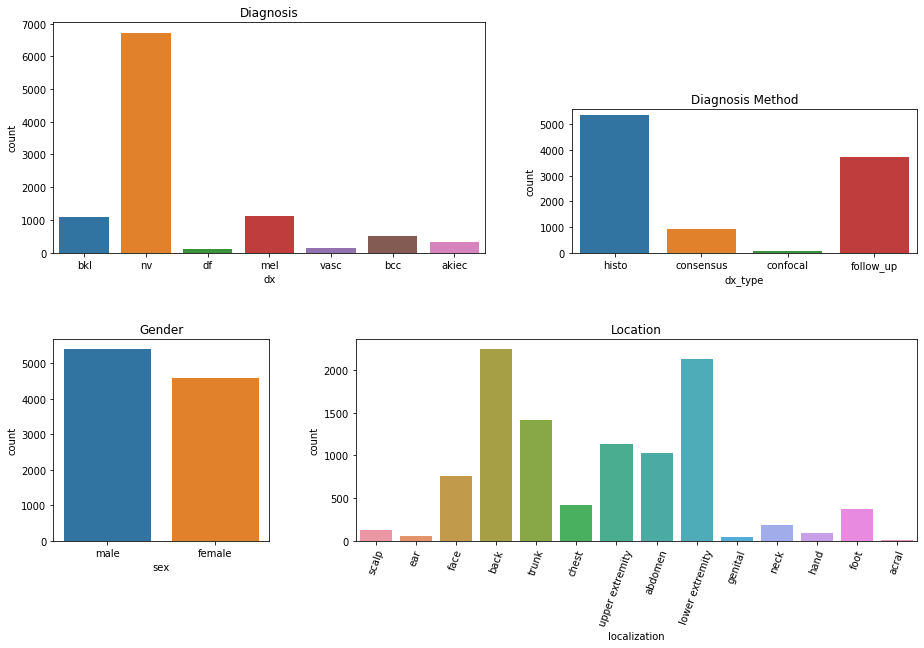

In [9]:
fig = plt.figure()

ax1 = fig.add_axes([0.1, 1.3, 1.0, 0.8])
ax2 = fig.add_axes([1.3, 1.3, 0.8, 0.5])
ax3 = fig.add_axes([0.1, 0.3, 0.5, 0.7])
ax4 = fig.add_axes([0.8, 0.3, 1.3, 0.7])

sns.countplot(data.dx, ax=ax1)
ax1.set_title('Diagnosis')

sns.countplot(data.dx_type, ax=ax2)
ax2.set_title('Diagnosis Method')

sns.countplot(data.sex, ax=ax3)
ax3.set_title('Gender')

sns.countplot(data.localization, ax=ax4)
ax4.set_title('Location')
plt.xticks(rotation=70)

plt.show()

Our target column ("Diagnosis") is heavily imbalanced, with almost 7000 of the 10015 in one category (nv). This will have an impact in our Machine Learning later. 

In both the “localization” and “sex” columns, there is a string “unknown” which probably refers to values not inputted.

#### Looking for missing values in the lesion and image id columns

To look for potential missing values in the image and lesion id columns, I compared each value against a regular expression. It seems that the general format is "HAM_(7 digit code)" and "ISIC_(7 digit code)", for lesion and image ids, respectively, and an input different from this format would thus be suspicious.

In [10]:
pattern1 = '^HAM_\d{7}$'
pattern2 = 'ISIC_\d{7}$'
selector = (~data.lesion_id.str.contains(pattern1))|(~data.image_id.str.contains(pattern2))
data[selector]

,Unnamed: 0,lesion_id,image_id,dx,dx_type,age,sex,localization


Looks like there were no missing values in those columns.

#### How the missing values could be filled

Since both "sex" and "age" has the same number of values not inputted, I was curious if there were some correlation between them, so I looked at columns where both are missing and columns where either one is missing to see if there are any patterns.

In [11]:
data = data.replace('unknown',np.nan)

In [12]:
age_and_sex_unknown = data[(data.sex.isnull()) & (data.age.isnull())]
print(age_and_sex_unknown.shape)
age_and_sex_unknown

(0, 8)


,Unnamed: 0,lesion_id,image_id,dx,dx_type,age,sex,localization


In [13]:
age_missing = data[(data.sex.notnull()) & (data.age.isnull())]
print(age_missing.shape)
age_missing

(0, 8)


,Unnamed: 0,lesion_id,image_id,dx,dx_type,age,sex,localization


In [14]:
sex_unknown = data[(data.sex.isnull()) & (data.age.notnull())]
print(sex_unknown.shape)
sex_unknown

(0, 8)


,Unnamed: 0,lesion_id,image_id,dx,dx_type,age,sex,localization


For the 47 rows in which both the age and the sex and not inputted, the localization is not inputted and the diagnosis method is "concensus" for all of them. For the others in which either age or sex is missing, there is only one missing value, and this appears true for rows in which the localization is unknown. 

In [15]:
loc_unknown = data[(data.localization == 'unknown')]
loc_unknown.head(10)

,Unnamed: 0,lesion_id,image_id,dx,dx_type,age,sex,localization


## Filling in blank values

I attempted to fill in the numerical and categorical variables using Random Forest Regressor and Random Forest Classifier, respectively. I chose random forest because it 
* has a high accuracy for for large datasets (unlike DecisionTree or kNN)
* captures relationships between variables (unlike Naive Bayes).
* doesn't have a lot of parameters to tune (unlike SVM).

### Age

In [16]:
#Generating target and feature tables using data with not null ages.
y = data[data.age.notnull()].age
X = pd.get_dummies(data[data.age.notnull()].drop(['age','lesion_id','image_id'],axis=1))

#Train test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)

In GridSearchCV I tuned the "n_estimators" parameter.

I used mean absolute error for the scoring because I think it's more interpretable compared to mean squared value or root of mean squared value. For example, if the mean absolute error is 10, then that means that on average, the predictions are 10 years off from the actual values. 

In [ ]:
#Parameter tuning
param_grid = {'n_estimators':np.arange(10,100,5)}
age_fill = RandomForestRegressor()
age_cv = GridSearchCV(age_fill, param_grid, scoring='neg_mean_absolute_error')
age_cv.fit(X_train, y_train)
print(age_cv.best_params_)
print(age_cv.best_score_)

C:\Users\songs\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


In [ ]:
#Fitting and predicting the for train/test datasets.
age_fill = RandomForestRegressor(n_estimators=35)
age_fill.fit(X_train, y_train)
y_pred = age_fill.predict(X_test)

mean_absolute_error(y_test,y_pred)

The above results seem pretty good to me, so I filled out the missing columns with this.

In [ ]:
#Converting dataframe to onehotencoded form.
X = pd.get_dummies(data.drop(['age','lesion_id','image_id'],axis=1))

#Creating features.
X_null = X.loc[data.age.isnull(), :]

#Filling in values
y_pred = age_fill.predict(X_null)
data.loc[data.age.isnull(), 'age'] = y_pred

### Sex

I basically repeated the same process as above, except with a classifier instead of a regressor.

In [ ]:
#Generating target and feature tables using data with not null values.
y = data[data.sex.notnull()].sex
X = pd.get_dummies(data[data.sex.notnull()].drop(['sex','lesion_id','image_id'],axis=1))

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)

In [ ]:
#Parameter tuning
param_grid = {'n_estimators':np.arange(10,100,5)}
sex_fill = RandomForestClassifier()
sex_cv = GridSearchCV(sex_fill, param_grid, scoring='accuracy')
sex_cv.fit(X_train, y_train)
print(sex_cv.best_params_)
print(sex_cv.best_score_)

In [ ]:
#Fitting and predicting the for train/test datasets.
sex_fill = RandomForestClassifier(n_estimators=75)
sex_fill.fit(X_train, y_train)
y_pred = sex_fill.predict(X_test)

accuracy_score(y_test,y_pred)

In [ ]:
#Filling in values
X = pd.get_dummies(data.drop(['sex','lesion_id','image_id'],axis=1))
X_null = X.loc[data.sex.isnull(), :]
y_pred = sex_fill.predict(X_null)

data.loc[data.sex.isnull(), 'sex'] = y_pred

### Location of Lesion

In [ ]:
#Generating target and feature tables using data with not null values.
y = data[data.localization.notnull()].localization
X = pd.get_dummies(data[data.localization.notnull()].drop(['localization','lesion_id','image_id'],axis=1))

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.3)

In [ ]:
#Parameter tuning
param_grid = {'n_estimators':np.arange(100,135,5)}
localization_fill = RandomForestClassifier()
localization_cv = GridSearchCV(localization_fill, param_grid, scoring='accuracy')
localization_cv.fit(X_train, y_train)
print(localization_cv.best_params_)
print(localization_cv.best_score_)

In [ ]:
#Fitting and predicting the for train/test datasets.
localization_fill = RandomForestClassifier(n_estimators=130)
localization_fill.fit(X_train, y_train)
y_pred = localization_fill.predict(X_test)

accuracy_score(y_test,y_pred)

In [ ]:
#Filling in values
X = pd.get_dummies(data.drop(['localization','lesion_id','image_id'],axis=1))
X_null = X.loc[data.localization.isnull(), :]
y_pred = localization_fill.predict(X_null)

data.loc[data.localization.isnull(), 'localization'] = y_pred

## Saving to csv

In [ ]:
data.to_csv(r'C:\Users\songs\Desktop\CSV files\dataverse_files\HAM10000_metadata.csv')